# Goal:
Create a web app that analyzes and synthesizes 2 users' spotify recent taste profiles so that we can create a playlist filled with brand new song recommendations for both of them to discover together. The playlist we curate will automatically end up in both of their spotify libraries. Would be a cool new way for people to socialize because the playlist is unique to them and can create a special experience for both to find new music together that matches their music tastes.

### Some useful links to get started: 

spotipy documentation: https://spotipy.readthedocs.io/en/2.13.0/ 

github of guy who made this code (give proper credit later): https://github.com/makispl/Spotify-Data-Analysis

he also has a useful medium article that gives steps on how to use spotify api and this code: https://towardsdatascience.com/can-a-data-scientist-replace-a-dj-spotify-manipulation-with-python-fbbd4a45ffd5

I've also created an app on spotify developers already and this is the client id: 0b2103231ba64a70885c27fbb38cfa97
and this is the client secret: 45d7d10e11474298abcb52df745e2b25

### plan
get top 50 from each user -> k=5 cluster 100 songs -> put 5 seed_songs/artists/genres into recommendations() function parameters -> keep calling function until 30 new songs that are not in either user's listen history

In [183]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from pandas.io.json import json_normalize

## Authorization Flow

In [184]:
# Declare the credentials
cid = '0b2103231ba64a70885c27fbb38cfa97'
secret = '45d7d10e11474298abcb52df745e2b25'
redirect_uri='http://localhost:7777/callback'
username = 'areddy12434'

# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

## Extract User's Top Medium Term Songs

In [185]:
user1_songs = pd.read_csv('User1_top_50_songs.csv')
user2_songs = pd.read_csv('User2_top_50_songs.csv')
temp = [user1_songs, user2_songs]
temp = pd.concat(temp)
temp.reset_index(drop=True,inplace=True)
print(temp)

    Unnamed: 0                                  artist  \
0            0                            Lil Uzi Vert   
1            1                            Lil Uzi Vert   
2            2                                JACKBOYS   
3            3                                Kid Cudi   
4            4                            Lil Uzi Vert   
..         ...                                     ...   
95          45                              Felix Snow   
96          46                                    Styx   
97          47                                    Russ   
98          48  Donnie Trumpet & The Social Experiment   
99          49                                 Whethan   

                               artist_uri  \
0   spotify:artist:4O15NlyKLIASxsJ0PrXPfz   
1   spotify:artist:4O15NlyKLIASxsJ0PrXPfz   
2   spotify:artist:7A8S43ryYdbWpJKeHRZRcq   
3   spotify:artist:0fA0VVWsXO9YnASrzqfmYu   
4   spotify:artist:4O15NlyKLIASxsJ0PrXPfz   
..                               

#### Extract Users' Top 50 Tracks' Audio Features

In [186]:
user1_list = []
for song in user1_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user1_list.append(row)
user1_df = pd.concat(user1_list)

user2_list = []
for song in user2_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user2_list.append(row)
user2_df = pd.concat(user2_list)

dfs = [user1_df, user2_df]
dfs = pd.concat(dfs)
dfs

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.817,0.656,10,-7.086,0,0.2770,0.0510,0.000000,0.1150,0.314,139.915,audio_features,0AhJag7VI8uFf3mJFsTwvf,spotify:track:0AhJag7VI8uFf3mJFsTwvf,https://api.spotify.com/v1/tracks/0AhJag7VI8uF...,https://api.spotify.com/v1/audio-analysis/0AhJ...,120076,4
0,0.771,0.654,8,-6.976,0,0.2980,0.0550,0.000000,0.2140,0.573,155.047,audio_features,56uXDJRCuoS7abX3SkzHKQ,spotify:track:56uXDJRCuoS7abX3SkzHKQ,https://api.spotify.com/v1/tracks/56uXDJRCuoS7...,https://api.spotify.com/v1/audio-analysis/56uX...,224955,4
0,0.594,0.676,2,-5.808,1,0.3440,0.1350,0.000000,0.1630,0.472,143.477,audio_features,40mjsnRjCpycdUw3xhS20g,spotify:track:40mjsnRjCpycdUw3xhS20g,https://api.spotify.com/v1/tracks/40mjsnRjCpyc...,https://api.spotify.com/v1/audio-analysis/40mj...,181145,4
0,0.806,0.809,1,-7.180,1,0.1590,0.1410,0.000086,0.0739,0.685,95.043,audio_features,3hR48Bj9Wgl6xunDG4nsRZ,spotify:track:3hR48Bj9Wgl6xunDG4nsRZ,https://api.spotify.com/v1/tracks/3hR48Bj9Wgl6...,https://api.spotify.com/v1/audio-analysis/3hR4...,189545,4
0,0.862,0.650,10,-6.978,0,0.3550,0.0207,0.000000,0.5680,0.658,131.194,audio_features,4lAQfuREAHG8IC0PiiigBt,spotify:track:4lAQfuREAHG8IC0PiiigBt,https://api.spotify.com/v1/tracks/4lAQfuREAHG8...,https://api.spotify.com/v1/audio-analysis/4lAQ...,115350,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.758,0.416,11,-7.897,0,0.0842,0.2950,0.000000,0.0958,0.457,100.018,audio_features,0Cm3Xy7wF0HogyeVRJ1DZs,spotify:track:0Cm3Xy7wF0HogyeVRJ1DZs,https://api.spotify.com/v1/tracks/0Cm3Xy7wF0Ho...,https://api.spotify.com/v1/audio-analysis/0Cm3...,157200,4
0,0.324,0.335,0,-15.595,1,0.0355,0.0990,0.000001,0.0995,0.141,119.513,audio_features,0PsbWiVtix5FoTZ1s00mEl,spotify:track:0PsbWiVtix5FoTZ1s00mEl,https://api.spotify.com/v1/tracks/0PsbWiVtix5F...,https://api.spotify.com/v1/audio-analysis/0Psb...,367000,4
0,0.743,0.507,2,-3.164,0,0.1350,0.6060,0.000000,0.1110,0.358,79.011,audio_features,5dM52n0cmm1Kt8abAP1l9Z,spotify:track:5dM52n0cmm1Kt8abAP1l9Z,https://api.spotify.com/v1/tracks/5dM52n0cmm1K...,https://api.spotify.com/v1/audio-analysis/5dM5...,161071,4
0,0.511,0.596,0,-6.560,1,0.2240,0.5300,0.000000,0.0798,0.554,158.063,audio_features,6fTdcGsjxlAD9PSkoPaLMX,spotify:track:6fTdcGsjxlAD9PSkoPaLMX,https://api.spotify.com/v1/tracks/6fTdcGsjxlAD...,https://api.spotify.com/v1/audio-analysis/6fTd...,226014,4


In [187]:
#normalize tempo feature
dfs.drop(['type','track_href','analysis_url','time_signature','duration_ms','uri','instrumentalness','liveness','loudness','key','mode'],1,inplace=True)
dfs.set_index('id',inplace=True)
dfs.head(1)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.051,0.314,139.915


In [188]:
dfs.describe()

,danceability,energy,speechiness,acousticness,valence,tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.691770,0.660068,0.205413,0.182442,0.495662,120.351220
std,0.153376,0.165149,0.158345,0.202386,0.223225,27.426881
min,0.147000,0.008780,0.027800,0.000008,0.026000,70.776000
25%,0.570750,0.551500,0.063475,0.027325,0.343750,99.501750
50%,0.729000,0.679000,0.179000,0.106000,0.472500,118.413000
75%,0.818000,0.796000,0.300250,0.266250,0.659000,139.855000
max,0.929000,0.933000,0.902000,0.899000,0.974000,177.728000


In [189]:
#Normalizing the Tempo
from sklearn import preprocessing

x = dfs[['tempo']].values.astype(float)

min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x)

df_normalized = pd.DataFrame(x_scaled)

df_normalized_array = df_normalized.to_numpy()

dfs['normalized_tempo'] = df_normalized_array

dfs = dfs.drop(columns="tempo")

dfs

,danceability,energy,speechiness,acousticness,valence,normalized_tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.2770,0.0510,0.314,0.646449
56uXDJRCuoS7abX3SkzHKQ,0.771,0.654,0.2980,0.0550,0.573,0.787933
40mjsnRjCpycdUw3xhS20g,0.594,0.676,0.3440,0.1350,0.472,0.679754
3hR48Bj9Wgl6xunDG4nsRZ,0.806,0.809,0.1590,0.1410,0.685,0.226896
4lAQfuREAHG8IC0PiiigBt,0.862,0.650,0.3550,0.0207,0.658,0.564908
...,...,...,...,...,...,...
0Cm3Xy7wF0HogyeVRJ1DZs,0.758,0.416,0.0842,0.2950,0.457,0.273412
0PsbWiVtix5FoTZ1s00mEl,0.324,0.335,0.0355,0.0990,0.141,0.455690
5dM52n0cmm1Kt8abAP1l9Z,0.743,0.507,0.1350,0.6060,0.358,0.076997


## K-Means Clustering

In [190]:
#get 20 clusters of x songs -> perform the recommendation function 20 times 
clusters = 20
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(dfs)
len(kmeans.labels_)

100

### Visualize Clustering

In [191]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
pca.fit(dfs) 
  
pca_data = pd.DataFrame(pca.transform(dfs)) 
  
print(pca_data.head())

          0         1         2
0  0.158719  0.139502 -0.159385
1  0.350895 -0.024310 -0.052862
2  0.237713  0.077149 -0.026466
3 -0.166872 -0.308549 -0.027768
4  0.175798 -0.189055 -0.040839


In [192]:
from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 

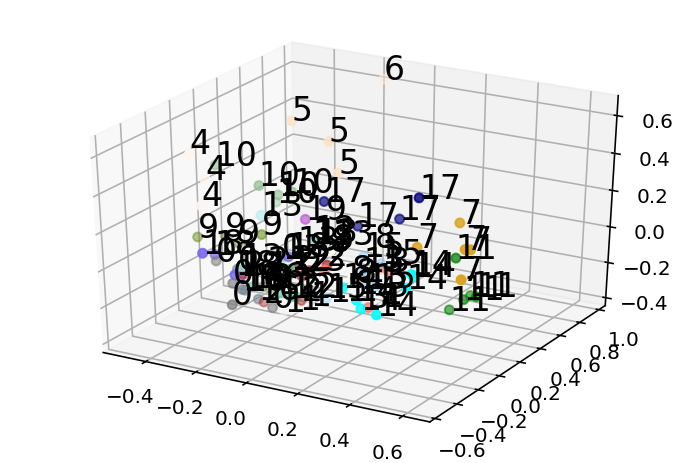

In [193]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
   
fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

plt.show()

### Cluster Analysis

In [194]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfs)
y_kmeans = kmeans.fit_predict(scaled)
y_kmeans

array([14, 16,  1, 11,  0,  5, 17, 14, 13,  6, 14, 14,  7,  1, 17,  9, 16,
        7, 10,  8,  9, 11,  8, 14, 19, 12,  1, 10, 14,  2,  9,  1, 13,  3,
        0, 17,  8, 17,  1, 16, 17,  3, 15, 19,  2, 16, 11, 19, 13,  2, 16,
        3,  3,  2, 12,  4,  8,  2,  7,  6,  7, 11,  4,  0,  7, 11,  8, 18,
       10, 15,  2, 16,  7,  3, 10, 15,  8, 14, 16, 14, 16,  8,  8,  7, 19,
        8, 17, 12,  8,  7, 16, 19, 12, 13, 11,  4,  2,  6,  9,  6])

In [195]:
dfs['cluster'] = y_kmeans
dfs['artist'] = temp.artist.tolist()
dfs['title'] = temp.song.tolist()
dfs.head()

,danceability,energy,speechiness,acousticness,valence,normalized_tempo,cluster,artist,title
id,,,,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.0510,0.314,0.646449,14,Lil Uzi Vert,I Can Show You
56uXDJRCuoS7abX3SkzHKQ,0.771,0.654,0.298,0.0550,0.573,0.787933,16,Lil Uzi Vert,Myron
40mjsnRjCpycdUw3xhS20g,0.594,0.676,0.344,0.1350,0.472,0.679754,1,JACKBOYS,GATTI
3hR48Bj9Wgl6xunDG4nsRZ,0.806,0.809,0.159,0.1410,0.685,0.226896,11,Kid Cudi,Leader Of The Delinquents
4lAQfuREAHG8IC0PiiigBt,0.862,0.650,0.355,0.0207,0.658,0.564908,0,Lil Uzi Vert,Strawberry Peels (feat. Young Thug & Gunna)


In [196]:
#visualize the feature 
dfs.loc[dfs['cluster'] == 2]

,danceability,energy,speechiness,acousticness,valence,normalized_tempo,cluster,artist,title
id,,,,,,,,,
1Eolhana7nKHYpcYpdVcT5,0.515,0.534,0.0768,0.181,0.426,0.000000,2,Jimi Hendrix,Little Wing
3aUFrxO1B8EW63QchEl3wX,0.580,0.469,0.1040,0.126,0.369,0.372102,2,KIDS SEE GHOSTS,Feel The Love
3g7XdOnYbeoinTCcLsElSa,0.567,0.585,0.1240,0.195,0.299,0.132779,2,Meek Mill,Shine
6U0FIYXCQ3TGrk4tFpLrEA,0.453,0.538,0.0638,0.449,0.516,0.488041,2,BROCKHAMPTON,SUGAR
3iIrtgucy1S2IMtozeYARI,0.732,0.568,0.0472,0.253,0.289,0.460047,2,JhenÃ© Aiko,Bed Peace
7jZHUhAmW5oq1cq6s8IxmK,0.683,0.481,0.0750,0.191,0.470,0.460253,2,ODESZA,Sun Models (feat. Madelyn Grant)
0PsbWiVtix5FoTZ1s00mEl,0.324,0.335,0.0355,0.099,0.141,0.455690,2,Styx,Come Sail Away


In [197]:
#6 k-means assumed to cluster genres, but we are using k=20
dfs.groupby(['cluster']).count()

,danceability,energy,speechiness,acousticness,valence,normalized_tempo,artist,title
cluster,,,,,,,,
0,3,3,3,3,3,3,3,3
1,5,5,5,5,5,5,5,5
2,7,7,7,7,7,7,7,7
3,5,5,5,5,5,5,5,5
4,3,3,3,3,3,3,3,3
5,1,1,1,1,1,1,1,1
6,4,4,4,4,4,4,4,4
7,8,8,8,8,8,8,8,8
8,10,10,10,10,10,10,10,10


In [198]:
#create list of lists of song ids to put into recommendation function
i=0
list_of_recs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while i<20:
    list_of_recs[i] = dfs.loc[dfs['cluster'] == i].index.to_list()
    i+=1
len(list_of_recs)
print(list_of_recs)

[['4lAQfuREAHG8IC0PiiigBt', '3RMVEnANWM9KAWrYshJgNO', '65mFuYYe8FBwBelMCGfhOV'], ['40mjsnRjCpycdUw3xhS20g', '1p1b9LdLJ0REuFJX9mYtFX', '5Pt83OUaK3K9C2if4C5JOk', '79s5XnCN4TJKTVMSmOx8Ep', '4v91QNfyj3uaYy5XyAT35a'], ['1Eolhana7nKHYpcYpdVcT5', '3aUFrxO1B8EW63QchEl3wX', '3g7XdOnYbeoinTCcLsElSa', '6U0FIYXCQ3TGrk4tFpLrEA', '3iIrtgucy1S2IMtozeYARI', '7jZHUhAmW5oq1cq6s8IxmK', '0PsbWiVtix5FoTZ1s00mEl'], ['1u8Fi9Nnb7PQVZlOmSvKgY', '1AzqpMy3yLYNITSOUrnL8i', '7fPuWrlpwDcHm5aHCH5D9t', '0y60itmpH0aPKsFiGxmtnh', '6K4t31amVTZDgR3sKmwUJJ'], ['1ooO1j7bseZCHaCFxVpoMq', '4sSu9BtWSCWRNjGD2AvqbG', '0Cm3Xy7wF0HogyeVRJ1DZs'], ['110w73fvP7BBkELWhT00MV'], ['6vegnfDS8DAEaCqWaPYGPy', '3s2Qd1rsWqbvOoxpFTRp8D', '5dM52n0cmm1Kt8abAP1l9Z', '08Kj0lvbsqAxzeUOBYZRL6'], ['0nbXyq5TXYPCO7pr3N8S4I', '2HfG5fTpLn87WmBYQmMUml', '4nK5YrxbMGZstTLbvj6Gxw', '7lQ8MOhq6IN2w8EYcFNSUk', '7FknBUKLWwjWszRK1N0jqe', '0nbXyq5TXYPCO7pr3N8S4I', '4DWAQLUA3lF3Ozcqni5UY9', '0uIbS3hBnqjJ9cVG0XmMHr'], ['73IdeGI8Gt1XxcaQ6vBsyD', '4sWGHlZGM1XA7TyWdtB

In [199]:
j = 0
adj_list_of_recs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while j<20:
    if len(list_of_recs[j]) < 6:
        adj_list_of_recs[j] = list_of_recs[j]
    else:
        adj_list_of_recs[j] = random.sample(list_of_recs[j], 5)
    j += 1

print(adj_list_of_recs)


[['4lAQfuREAHG8IC0PiiigBt', '3RMVEnANWM9KAWrYshJgNO', '65mFuYYe8FBwBelMCGfhOV'], ['40mjsnRjCpycdUw3xhS20g', '1p1b9LdLJ0REuFJX9mYtFX', '5Pt83OUaK3K9C2if4C5JOk', '79s5XnCN4TJKTVMSmOx8Ep', '4v91QNfyj3uaYy5XyAT35a'], ['0PsbWiVtix5FoTZ1s00mEl', '6U0FIYXCQ3TGrk4tFpLrEA', '3iIrtgucy1S2IMtozeYARI', '1Eolhana7nKHYpcYpdVcT5', '3aUFrxO1B8EW63QchEl3wX'], ['1u8Fi9Nnb7PQVZlOmSvKgY', '1AzqpMy3yLYNITSOUrnL8i', '7fPuWrlpwDcHm5aHCH5D9t', '0y60itmpH0aPKsFiGxmtnh', '6K4t31amVTZDgR3sKmwUJJ'], ['1ooO1j7bseZCHaCFxVpoMq', '4sSu9BtWSCWRNjGD2AvqbG', '0Cm3Xy7wF0HogyeVRJ1DZs'], ['110w73fvP7BBkELWhT00MV'], ['6vegnfDS8DAEaCqWaPYGPy', '3s2Qd1rsWqbvOoxpFTRp8D', '5dM52n0cmm1Kt8abAP1l9Z', '08Kj0lvbsqAxzeUOBYZRL6'], ['7FknBUKLWwjWszRK1N0jqe', '0nbXyq5TXYPCO7pr3N8S4I', '2HfG5fTpLn87WmBYQmMUml', '4nK5YrxbMGZstTLbvj6Gxw', '0uIbS3hBnqjJ9cVG0XmMHr'], ['6kQzmbSkHGexuwD9D3zNom', '4sWGHlZGM1XA7TyWdtBAbA', '1LeItUMezKA1HdCHxYICed', '2G7V7zsVDxg1yRsu7Ew9RJ', '6FzjJPwf5JzzFOei7h6Qrp'], ['1BXRj9TBkcxhBWm0kJZ9v3', '7In1dVQMQ9T7NFVD0

-------------------------------------------------------------------------------------------

In [200]:
#Time to Get Recommendation
k = 0
list_of_recommendations = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while k < 20:
    if len(adj_list_of_recs[k]) < 3:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=1)
    elif len(adj_list_of_recs[k]) < 5:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=2)
    else:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=3)
    k += 1

list_of_recommendations[0]

{'tracks': [{'album': {'album_type': 'ALBUM',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/699OTQXzgjhIYAHMy9RyPD'},
      'href': 'https://api.spotify.com/v1/artists/699OTQXzgjhIYAHMy9RyPD',
      'id': '699OTQXzgjhIYAHMy9RyPD',
      'name': 'Playboi Carti',
      'type': 'artist',
      'uri': 'spotify:artist:699OTQXzgjhIYAHMy9RyPD'}],
    'available_markets': ['AD',
     'AE',
     'AR',
     'AT',
     'AU',
     'BE',
     'BG',
     'BH',
     'BO',
     'BR',
     'CA',
     'CH',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DE',
     'DK',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FR',
     'GB',
     'GR',
     'GT',
     'HK',
     'HN',
     'HU',
     'ID',
     'IE',
     'IL',
     'IN',
     'IS',
     'IT',
     'JO',
     'JP',
     'KW',
     'LB',
     'LI',
     'LT',
     'LU',
     'LV',
     'MA',
     'MC',
     'MT',
     'MX',
     'MY',
     'NI',
     'NL',
     'NO',

In [201]:
pd.json_normalize(list_of_recommendations[15], record_path='tracks').id

type(pd.json_normalize(list_of_recommendations[15], record_path='tracks').id)


pandas.core.series.Series

In [202]:
list_of_recommendations_converted = []
l = 0

while l < 20:
    list_of_recommendations_converted.append(pd.json_normalize(list_of_recommendations[l], record_path='tracks').id.tolist())
    l += 1

list_of_recommendations_to_delete = []
m = 0
while m < 20:
    if len(list_of_recommendations_converted[m]) < 2:
        list_of_recommendations_to_delete.append(list_of_recommendations_converted[m])
        print(list_of_recommendations_converted[m])
    m += 1

flatlist_of_recommendations_converted = [item for elem in list_of_recommendations_converted for item in elem]

flatlist_of_recommendations_to_delete = [item for elem in list_of_recommendations_to_delete for item in elem]

all_recommendations = [i for i in flatlist_of_recommendations_converted if i not in flatlist_of_recommendations_to_delete] 

['4JdZoF2MbQNVjU6YMXGGBf']
['7GcbUQUvw2TIfmDfya8Jgv']


## Create the New Playlist
Next, we are going to create a new playlist and add to it all the tracks we ended up selecting:

In [203]:
# Authorization flow

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [204]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [205]:
create_playlist(sp, username, 'Spotify Discover Together', 'A joint playlist created from both of your favorite songs!')

In [206]:
##Def Fetch Playlist Function

def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [207]:
# Find the new playlist's id
fetch_playlists(sp,username)

,id,name,#tracks
0,57B5MYZCCwwb3gm8Wy6zhs,Spotify Discover Together,0
1,5sU8tSZ5y9JH3jgYJZfjky,Spotify Discover Together,46
2,3KcN3Z2SOrgM4POy9l8Yzy,Spotify Discover Together,48
3,0pYo4IOpxoKQC82OMu95Un,Spotify Discover Together,97
4,77dMqq45SPyCxkVQeL1AtI,Spotify Discover Together,35
5,7HCyrxv9JX8MsoFoTp6y25,Spotify Discover Together,36
6,4Wb7aqH3HbpZ4mcRXwMU4h,Spin Workout #7,14
7,7LA9IJ8sNigtqsaNBvwQ3l,Spin Playlist #6,15
8,65slnqeZoVRPPCpirC0HlM,Spin Playlist #5,16
9,0lFPNYEPAHZSdwtOjnDw6l,Spin Playlist #4,16


In [208]:
extracted_id = fetch_playlists(sp,username).id[0]

In [209]:
sp.user_playlist_add_tracks(username, extracted_id, all_recommendations, position=None)

{'snapshot_id': 'MyxmMjY1MzI4ODkzYWRkMWMyYjViNzJjZTliMWIyOTBiOTRkMzM1YjM1'}